In [133]:
import bz2
import json
import pandas as pd
from datetime import datetime
import numpy as np
import logging
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import vaderSentiment
import fastparquet
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow
import warnings
warnings.filterwarnings('ignore')

# First approach of the sentiment analysis 

In [134]:
sid = SentimentIntensityAnalyzer()
text = "I am really extremely happy"
scores = sid.polarity_scores(text)
print(TextBlob(text).sentiment.polarity)
print(scores)

0.8
{'neg': 0.0, 'neu': 0.484, 'pos': 0.516, 'compound': 0.6453}


## Quotes Pre-processing

In [135]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)


In [136]:
def full_preprocess(quote):
    '''
    Pre processing function:
        -Expand the words in the quote
        -Put all quotes in lowercase
        -Remove digits and words containing digits
        -Remove punctuation
    '''
    quote = expand_contractions(quote)
    quote=quote.lower()
    quote=re.sub(r'\w*\d\w*','', quote)
    quote=re.sub('[%s]' % re.escape(string.punctuation), '', quote)
    quote=re.sub(' +',' ',quote)
    return quote
import string
sid = SentimentIntensityAnalyzer()


## Polarity scores of quotes using Vader & TextBlob

In [137]:
def sentiment(df):
    '''
    Computes the sentiment value of all quote of a dataframe using the textblob and vader NLP models.
    '''
    df['Quote'] = df.apply(lambda row: full_preprocess(row.Quote),  axis = 1)
    df['TextBlob'] = df.apply(lambda row: TextBlob(row.Quote).sentiment.polarity,  axis = 1)
    df['Vader'] = df.apply(lambda row: sid.polarity_scores(row.Quote),  axis = 1)
    df['Vader_neg'] = df.apply(lambda row: row.Vader['neg'],  axis = 1)
    df['Vader_neu'] = df.apply(lambda row: row.Vader['neu'],  axis = 1)
    df['Vader_pos'] = df.apply(lambda row: row.Vader['pos'],  axis = 1)
    df['Vader_com'] = df.apply(lambda row: row.Vader['compound'],  axis = 1)
    df['mean_vader_blob'] = df.apply(lambda row: np.mean([row.TextBlob, row.Vader_com]),  axis = 1)
    df = df.reset_index()
    return df


## Extract only quotes from dataset for Barack Obama.

In [ ]:
for year in range(2008,2021):
    path_to_out = "obama_chunks.bz2"
    with bz2.open('data/Quotebank/quotes-{}.json.bz2'.format(year), 'rb') as s_file:
        with bz2.open(path_to_out, 'wb') as d_file:
            for instance in tqdm(s_file):
                instance = json.loads(instance) # loading a sample
                speaker = instance['speaker'] # extracting list of links
                if 'Obama' in speaker:
                    d_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing in the new file

In [138]:
arr = os.listdir('ObamaChunks/')

In [139]:
quotes = []
index =0
for chunk in arr:
    with bz2.open('ObamaChunks/'+chunk, 'rb') as s_file:
        for ins in tqdm(s_file): 
            quotes.append([(re.findall(rb"\"speaker\":.+(?=\"qids)",ins)),(re.findall(rb"\"quotation\":.+(?=\"speaker)",ins)),(re.findall(rb"\"date\":.+(?=\"numOccurrences)",ins))])
quotes = [[quotes[i][0][0].decode(),quotes[i][1][0].decode(),quotes[i][2][0].decode()] for i in range(len(quotes))]
quotes = [[i[0][11:-2],i[1][13:-3],i[2][8:-2]] for i in quotes]
Obama_df = pd.DataFrame(quotes,  columns =['Speaker','Quote','Date'])

16990it [00:01, 10707.95it/s]
76475it [00:05, 13636.55it/s]
2298it [00:00, 9428.19it/s]
2379it [00:00, 5758.93it/s]
19172it [00:01, 13568.83it/s]
47493it [00:04, 10825.62it/s]
2263it [00:00, 18514.12it/s]
1629it [00:00, 7932.65it/s]
79892it [00:05, 14768.11it/s]
1252it [00:00, 7309.01it/s]
54750it [00:04, 12891.71it/s]
9453it [00:00, 16635.50it/s]


In [140]:
#set the date as index, useful for plotting
Obama_df['Date'] = pd.to_datetime(Obama_df['Date'],format="\"%Y-%m-%d %H:%M:%S\"")
Obama_df.set_index('Date',inplace=True)

In [141]:
Obama_df['Speaker'].unique()
whiteListObama = ['"President Barack Obama"','"President Obama"','"Barack Obama"','"president Barack Obama"' ]
Obama_df = Obama_df.loc[Obama_df['Speaker'].isin(whiteListObama)]

In [142]:
Obama_df

,Speaker,Quote
Date,,
2017-09-21 11:33:13,"""Barack Obama""","""As you get older, your responsibilities grow."
2017-10-11 17:19:27,"""Barack Obama""","""Obama's great. Obama is giving people hope. N..."
2017-11-09 10:41:00,"""president Barack Obama""","""Or at least being willing to."
2017-12-27 13:51:50,"""President Barack Obama""","""Social media is a really powerful tool for pe..."
2017-05-03 18:02:11,"""President Barack Obama""","""Spike Lee, Chance the Rapper, Bruce Springsteen."
...,...,...
2019-09-12 19:14:22,"""President Obama""","""the reverse image of Conrad's dark savages."
2019-04-11 18:35:00,"""President Barack Obama""","""There is no way an opportunity like this to s..."
2019-07-10 21:34:59,"""President Barack Obama""","""already apprehend and deport hundreds of thou..."


In [143]:
#compute sentiment analysis on quotes of the speaker Barack Obama.
sentiment(Obama_df)

,Date,Speaker,Quote,TextBlob,Vader,Vader_neg,Vader_neu,Vader_pos,Vader_com,mean_vader_blob
0,2017-09-21 11:33:13,"""Barack Obama""",as you get older your responsibilities grow,0.166667,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,0.083333
1,2017-10-11 17:19:27,"""Barack Obama""",obama is great obama is giving people hope not...,0.442857,"{'neg': 0.0, 'neu': 0.628, 'pos': 0.372, 'comp...",0.000,0.628,0.372,0.9843,0.713579
2,2017-11-09 10:41:00,"""president Barack Obama""",or at least being willing to,-0.025000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,-0.012500
3,2017-12-27 13:51:50,"""President Barack Obama""",social media is a really powerful tool for peo...,-0.022917,"{'neg': 0.0, 'neu': 0.797, 'pos': 0.203, 'comp...",0.000,0.797,0.203,0.6240,0.300542
4,2017-05-03 18:02:11,"""President Barack Obama""",spike lee chance the rapper bruce springsteen,0.000000,"{'neg': 0.0, 'neu': 0.75, 'pos': 0.25, 'compou...",0.000,0.750,0.250,0.2500,0.125000
...,...,...,...,...,...,...,...,...,...,...
290440,2019-09-12 19:14:22,"""President Obama""",the reverse image of conrad is dark savages,-0.150000,"{'neg': 0.327, 'neu': 0.673, 'pos': 0.0, 'comp...",0.327,0.673,0.000,-0.5267,-0.338350
290441,2019-04-11 18:35:00,"""President Barack Obama""",there is no way an opportunity like this to sp...,0.000000,"{'neg': 0.047, 'neu': 0.789, 'pos': 0.164, 'co...",0.047,0.789,0.164,0.6705,0.335250
290442,2019-07-10 21:34:59,"""President Barack Obama""",already apprehend and deport hundreds of thous...,0.000000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,0.000000
290443,2019-06-03 22:43:29,"""President Barack Obama""",alvin ailey delivered both through his life an...,0.000000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,0.000000


Text(0.5, 0, 'Date')

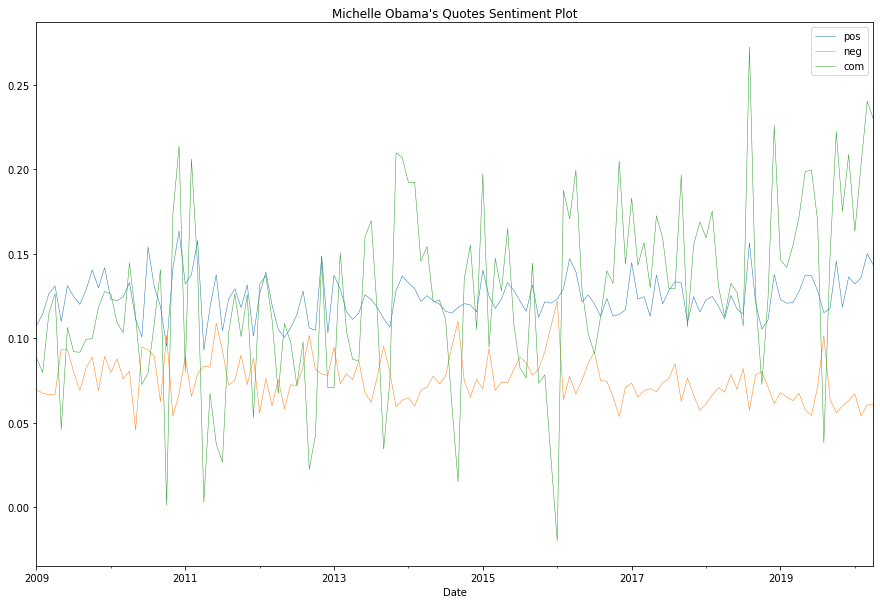

In [144]:
#Plot mean sentiment values over the 2012 year
freq = 'M'
pos = Obama_df['Vader_pos'].resample(freq).mean()
neg = Obama_df['Vader_neg'].resample(freq).mean()
com = Obama_df['Vader_com'].resample(freq).mean()
fig, axs = plt.subplots(sharex=True,figsize=(15,10))
axs.title.set_text('Michelle Obama\'s Quotes Sentiment Plot')

pos.plot(linewidth=0.5,ax = axs, label='pos')
neg.plot(linewidth=0.5,ax = axs,label='neg')
#neu.plot(linewidth=0.5,ax = axs)
com.plot(linewidth=0.5,ax = axs,label='com')
plt.legend()
plt.xlabel('Date')

### MEDICAL CLUSTER PLOTS

In [2]:
# load clusters. Medical cluster is N°2
cluster = pd.read_parquet('data/cluster.parquet')

In [3]:
# create dictionnary of speakers id -> [occupations]
medical = cluster.loc[cluster['cluster']==2]
medicalIdList = medical.ID.to_list()
speaker_attributes = pd.read_parquet('data/speaker_attributes.parquet')
dict_SId_OccId = dict(zip(speaker_attributes.id, speaker_attributes.occupation))


In [ ]:
assert False
#create medical bz2 file of quotes for 2012 quotes.
path_to_out = "medical_2012.bz2"
with bz2.open('data/Quotebank/quotes-2012.json.bz2', 'rb') as s_file:
    with bz2.open(path_to_out, 'wb') as d_file:
        for instance in tqdm(s_file):
            #print(instance)
            instance = json.loads(instance) # loading a sample
            id_ = instance['qids']
            for quid in id_:
                occupations = dict_SId_OccId.get(str(quid))
                if (not (occupations is None)) and (set(occupations) & set(medicalIdList)):
                    #print('id:',id_,'occ:', occupations)
                    d_file.write((json.dumps(instance)+'\n').encode('utf-8'))

In [4]:
assert False
#complete medical ds with all years 2008-2020:
for i in range(8,21):
    if i != 12:
        print("working on medical_20{:02d}.bz2".format(i))
        path_to_out = "medical_20{:02d}.bz2".format(i)
        with bz2.open("data/Quotebank/quotes-20{:02d}.json.bz2".format(i), 'rb') as s_file:
            with bz2.open(path_to_out, 'wb') as d_file:
                for instance in tqdm(s_file):
                    instance = json.loads(instance) # loading a sample
                    id_ = instance['qids']
                    for quid in id_:
                        occupations = dict_SId_OccId.get(str(quid))
                        if (not (occupations is None)) and (set(occupations) & set(medicalIdList)):
                            #print('id:',id_,'occ:', occupations)
                            d_file.write((json.dumps(instance)+'\n').encode('utf-8'))

1705it [00:00, 17048.23it/s]

working on medical_2017.bz2


26611588it [20:49, 21298.39it/s]
2186it [00:00, 21439.54it/s]

working on medical_2018.bz2


27228451it [18:15, 24861.32it/s]
2435it [00:00, 24337.14it/s]

working on medical_2019.bz2


21763302it [15:18, 23692.29it/s]
2397it [00:00, 21191.88it/s]

working on medical_2020.bz2


5244449it [03:47, 23096.91it/s]


In [7]:
#load all medical speakers quotes from all years
quotes = []
index =0
for i in range(8,21):
    path_med = "data/medical_quotes/medical_20{:02d}.bz2".format(i)
    with bz2.open(path_med, 'rb') as s_file:
        for ins in tqdm(s_file): 
            quotes.append([(re.findall(rb"\"speaker\":.+(?=\"qids)",ins)),(re.findall(rb"\"quotation\":.+(?=\"speaker)",ins)),(re.findall(rb"\"date\":.+(?=\"numOccurrences)",ins))])
quotes = [[quotes[i][0][0].decode(),quotes[i][1][0].decode(),quotes[i][2][0].decode()] for i in range(len(quotes))]
quotes = [[i[0][11:-2],i[1][13:-3],i[2][8:-2]] for i in quotes]
medical_df = pd.DataFrame(quotes,  columns =['speaker','quote','date'])

4945it [00:00, 20538.22it/s]
29277it [00:01, 22343.31it/s]
23513it [00:01, 21483.92it/s]
25658it [00:01, 22199.44it/s]
26030it [00:01, 21537.82it/s]
19976it [00:00, 20532.57it/s]
18973it [00:00, 22061.54it/s]
21170it [00:01, 18936.37it/s]
12158it [00:00, 20176.42it/s]
22461it [00:01, 18206.45it/s]
23743it [00:01, 15101.94it/s]
16522it [00:00, 20782.99it/s]
4031it [00:00, 19984.02it/s]


In [61]:
sentiment(medical_df)

,date,speaker,quote,TextBlob,Vader_com,mean_vader_blob
0,2008-10-08 14:54:41,"""jane seymour""",obedient in all things,0.400000,0.0000,0.200000
1,2008-10-28 17:23:43,"""steve chadwick""",the projects are a great example of collaborat...,0.228571,0.9260,0.577286
2,2008-12-19 16:05:57,"""robert ellis""",he was taken in a second two seconds no way no...,0.000000,0.5702,0.285100
3,2008-11-20 08:02:44,"""abdul rahman""",if you are unhappy with our woeful criminal ju...,-0.500000,-0.9246,-0.712300
4,2008-11-18 01:34:48,"""iris evans""",and that will be tragic,-0.750000,-0.4588,-0.604400
...,...,...,...,...,...,...
248452,2020-03-17 20:41:17,"""Phillipe Nover""",this will continue until we have the ability t...,0.197619,0.6369,0.417260
248453,2020-02-05 14:25:38,"""Mark Pearson""",with the backing of fuel ventures we are in th...,0.147619,0.9647,0.556160
248454,2020-03-03 07:38:03,"""Rachel Robinson""",at the moment we are in the containment phase ...,0.000000,0.7650,0.382500
248455,2020-03-02 16:09:01,"""Abdul Rahman""",for those who are interested a written applica...,0.250000,0.7003,0.475150


In [11]:
#set date as index for plotting
medical_df.set_index('date', inplace=True)

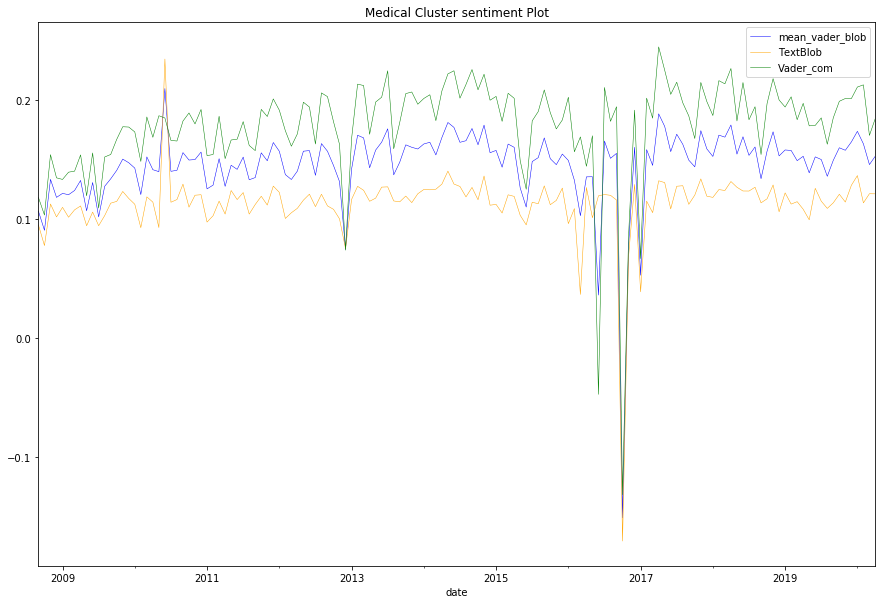

In [73]:
#frequency freq: D-day, W-week, M-month, Y-year...
freq = 'M'
medical_mean_mean = medical_df['mean_vader_blob'].resample(freq).mean()
medical_mean_blob = medical_df['TextBlob'].resample(freq).mean()
medical_mean_Vad = medical_df['Vader_com'].resample(freq).mean()

fig, axs = plt.subplots(sharex=True,figsize=(15,10))
axs.title.set_text('Medical Cluster sentiment Plot')


medical_mean_mean.plot(linewidth=0.5,ax = axs,color='blue')
medical_mean_blob.plot(linewidth=0.5,ax = axs,color='orange')
medical_mean_Vad.plot(linewidth=0.5,ax = axs,color='green')

axs.legend()

# Perform sentiment analysis over all quotes.

In [ ]:
assert False
for year in range(8,21):
    
    for month in range(1,13):
        globals()[f'month_{month}'] = open(f'month_means/month_{year}-{month}.bz2', 'w')
        globals()['month_{:02d}_mean'.format(month)] = [0,0,0,0]

    with bz2.open('data/Quotebank/quotes-20{:02d}.json.bz2'.format(year), 'rb') as s_file:
        for index, instance in tqdm(enumerate(s_file)):
            if index%2==0:
                instance = json.loads(instance)
                quote = instance['quotation'] 
                date = instance['date'] 
                quote = full_preprocess(quote)
                vaderscore = sid.polarity_scores(quote)
                globals()['month_{}_mean'.format(date[5:7])][0]+=1
                globals()['month_{}_mean'.format(date[5:7])][1]+=vaderscore['pos']
                globals()['month_{}_mean'.format(date[5:7])][2]+=vaderscore['neg']
                globals()['month_{}_mean'.format(date[5:7])][3]+=vaderscore['compound']
    for month in range(1,13):
        for j in range(3):
            try:
                globals()[f'month_{month}'].write('{},'.format(j)+str(globals()['month_{:02d}_mean'.format(month)][j+1]/globals()['month_{:02d}_mean'.format(month)][0])+'\n')
            except:
                print("no luck, for  {} {}".format(year,month))
        globals()[f'month_{month}'].close()

In [145]:
import pandas as pd
df = pd.DataFrame(columns = ['date','pos','neg','com'])
for year in range(8,21):
    for month in range(1,13):
        f =  open(f'month_means/month_{year}-{month}.bz2', 'r').read()
        f = f.split('\n')
        try:
            df2 = {'date':'20{:02d}-{:02d}'.format(year,month), 'pos': float(f[0][2:]),'neg':float(f[1][2:]), 'com':float(f[2][2:])}
        
        
            df = df.append(df2, ignore_index = True)
        except:
            pass
        
    

Text(0.5, 0, 'Date')

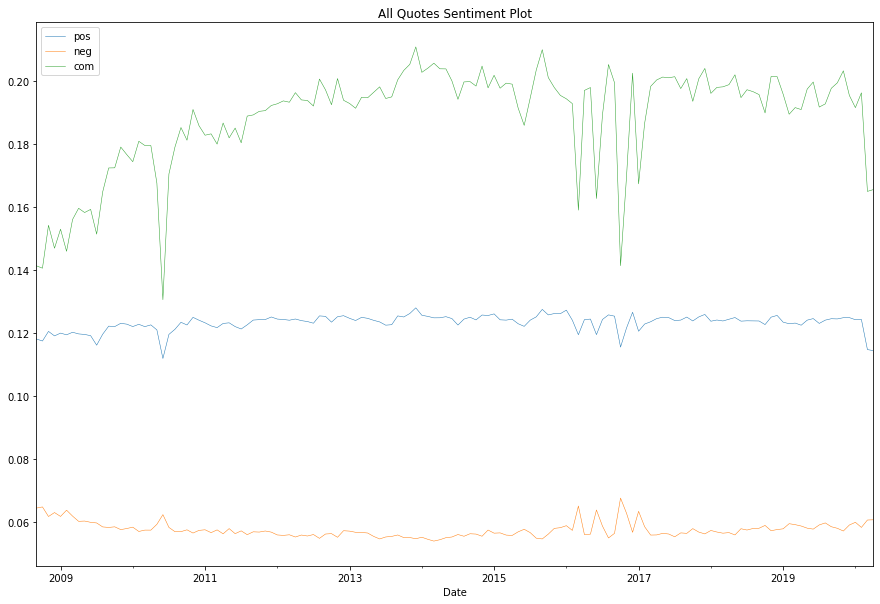

In [147]:
df['date'] = pd.to_datetime(df['date'],format="%Y-%m")
df.set_index('date', inplace=True)
freq = 'M'
pos = df['pos']
neg = df['neg']
com = df['com']
com_std = df['com'].resample(freq).std()
fig, axs = plt.subplots(sharex=True,figsize=(15,10))
axs.title.set_text('All Quotes Sentiment Plot')

pos.plot(linewidth=0.5,ax = axs, label='pos')
neg.plot(linewidth=0.5,ax = axs,label='neg')
#neu.plot(linewidth=0.5,ax = axs)
com.plot(linewidth=0.5,ax = axs,label='com')
plt.legend()
plt.xlabel('Date')
